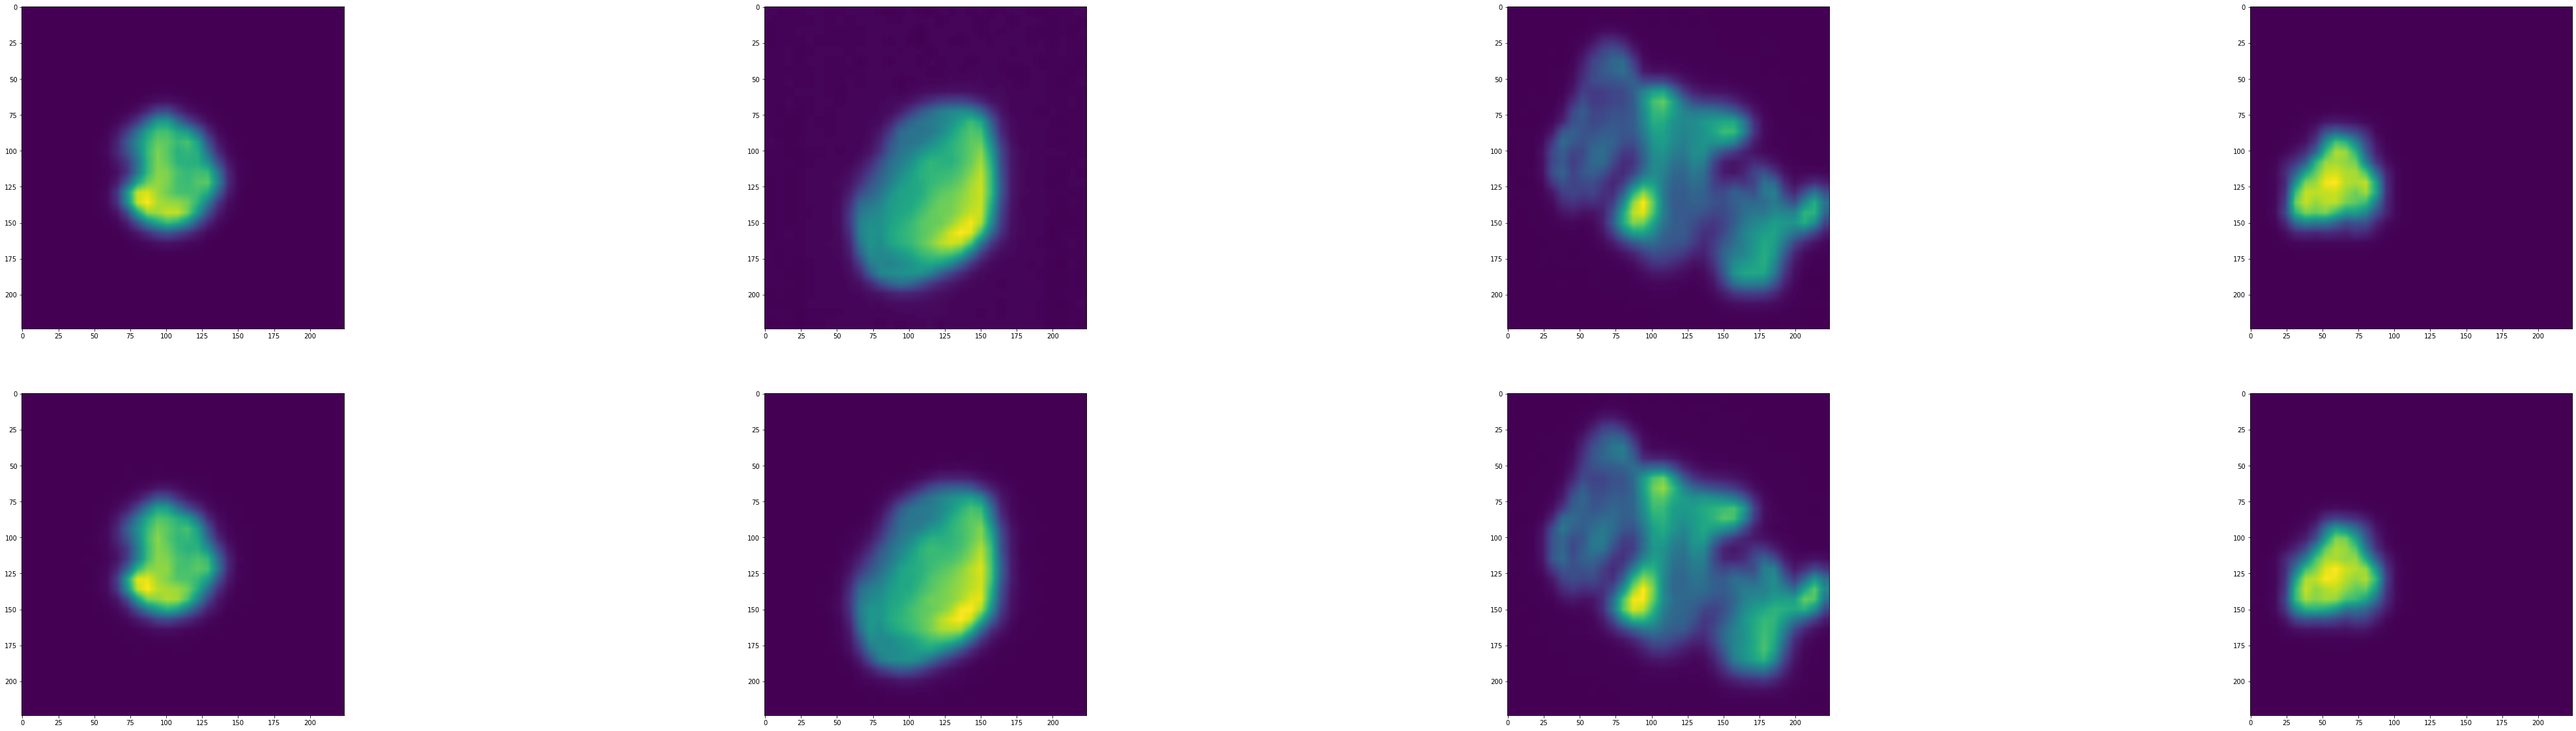

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
from torchvision import transforms
import pydicom
from PIL import Image
import cv2

transform_X = transforms.Compose([

    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: print(x.shape) ),
    transforms.Lambda(lambda x: x / x.max())
    
])

transform_Y = transforms.Compose([

    transforms.ToPILImage(),
    transforms.Resize((164,164)),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: print(x.shape) ),
    transforms.Lambda(lambda x: x / x.max())
    
])

transform = transforms.Compose([

    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / x.max())
    
])

BATCH_SIZE = 4

class custom_dataset(Dataset):

    def __init__(self, root, transform_X, transform_Y):

        self.root = root
        self.transform_X = transform_X
        self.transform_Y = transform_Y
        self.folders = os.listdir(root)
        self.X_path = os.listdir(root+self.folders[1])
        self.Y_path = os.listdir(root+self.folders[0])
        self.dataset_length = len(self.X_path)
        
    def __getitem__(self, index):
         
        X_path = self.root+self.folders[1]+'//'+self.X_path[index]
        img = Image.open(X_path)
        X = np.array(img)

        Y_path = self.root+self.folders[0]+'//'+self.Y_path[index]
        img = Image.open(Y_path)
        Y = np.array(img)

        X = self.transform_X(X)
        Y = self.transform_Y(Y)

        return X,Y

    def __len__(self):
        return self.dataset_length

root_train = "dataset\\train\\"
root_val = "dataset\\test\\" 

train_dataset = custom_dataset(root_train, transform, transform)
val_dataset = custom_dataset(root_val, transform, transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, 
                        shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, 
                        shuffle=True)

plt.figure(figsize = (160, 20))

for X,Y in train_loader:
    i = 0
    for x in X:
        plt.subplot(2, 8, i+1)
        plt.imshow(x.permute(1,2,0))
        i+=1
    i = 0
    for y in Y:
        plt.subplot(2, 8, i+8+1)
        plt.imshow(y.permute(1,2,0))
        i+=1
    break

In [3]:
from networks import define_G, define_D, GANLoss, get_scheduler, update_learning_rate

PATH = "checkpoint\\facades\\netG_model_epoch_1.pth"
checkpoint = torch.load(PATH)
model = define_G(1, 1, 64, 'batch', False, 'normal', 0.02, 'cpu')
model.load_state_dict({c[0]:c[1] for c in checkpoint.named_buffers()} | {c[0]:c[1] for c in checkpoint.named_parameters()} | {c[0]:c[1] for c in checkpoint.named_children()})
model.eval()

torch.cuda.empty_cache()
model.to('cpu')
model.eval()
plt.figure(figsize=(40,10))

for X,Y in val_loader:

    for x,y in zip(X,Y):

        plt.subplot(141)
        plt.imshow(x.squeeze(0))
        plt.title("Reference", fontsize=35)
        plt.subplot(142)
        plt.title("Evaluated", fontsize=35)
        plt.imshow(y.squeeze(0))
        output = model(x.unsqueeze(0))
        plt.subplot(143)
        plt.title("Predicted", fontsize=35)
        plt.imshow(output.cpu().data.squeeze(0).squeeze(0))
        y = y.cpu().data.squeeze(0)
        output = output.cpu().data.squeeze(0)
        plt.subplot(144)
        hits = abs(y - output)
        threshold = 1e-2
        hits[hits<=threshold] = 1
        hits[hits!=1] = 0
        plt.imshow(hits.squeeze(0))
        plt.title("Hits with threshold difference {}".format(threshold), fontsize=35)
        break

    break

initialize network with normal


RuntimeError: Error(s) in loading state_dict for ResnetGenerator:
	size mismatch for inc.inconv.1.weight: copying a param with shape torch.Size([128, 1, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7, 7]).
	size mismatch for inc.inconv.2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for inc.inconv.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for inc.inconv.2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for inc.inconv.2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down1.down.0.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for down1.down.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down1.down.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down1.down.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down1.down.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down2.down.0.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for down2.down.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down2.down.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down2.down.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down2.down.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.0.conv_block.1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.0.conv_block.2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.0.conv_block.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.0.conv_block.2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.0.conv_block.2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.0.conv_block.5.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.0.conv_block.6.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.0.conv_block.6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.0.conv_block.6.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.0.conv_block.6.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.1.conv_block.1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.1.conv_block.2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.1.conv_block.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.1.conv_block.2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.1.conv_block.2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.1.conv_block.5.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.1.conv_block.6.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.1.conv_block.6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.1.conv_block.6.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.1.conv_block.6.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.2.conv_block.1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.2.conv_block.2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.2.conv_block.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.2.conv_block.2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.2.conv_block.2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.2.conv_block.5.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.2.conv_block.6.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.2.conv_block.6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.2.conv_block.6.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.2.conv_block.6.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.3.conv_block.1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.3.conv_block.2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.3.conv_block.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.3.conv_block.2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.3.conv_block.2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.3.conv_block.5.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.3.conv_block.6.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.3.conv_block.6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.3.conv_block.6.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.3.conv_block.6.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.4.conv_block.1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.4.conv_block.2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.4.conv_block.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.4.conv_block.2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.4.conv_block.2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.4.conv_block.5.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.4.conv_block.6.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.4.conv_block.6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.4.conv_block.6.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.4.conv_block.6.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.5.conv_block.1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.5.conv_block.2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.5.conv_block.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.5.conv_block.2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.5.conv_block.2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.5.conv_block.5.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.5.conv_block.6.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.5.conv_block.6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.5.conv_block.6.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.5.conv_block.6.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.6.conv_block.1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.6.conv_block.2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.6.conv_block.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.6.conv_block.2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.6.conv_block.2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.6.conv_block.5.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.6.conv_block.6.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.6.conv_block.6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.6.conv_block.6.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.6.conv_block.6.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.7.conv_block.1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.7.conv_block.2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.7.conv_block.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.7.conv_block.2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.7.conv_block.2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.7.conv_block.5.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.7.conv_block.6.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.7.conv_block.6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.7.conv_block.6.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.7.conv_block.6.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.8.conv_block.1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.8.conv_block.2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.8.conv_block.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.8.conv_block.2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.8.conv_block.2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.8.conv_block.5.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resblocks.8.conv_block.6.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.8.conv_block.6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.8.conv_block.6.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resblocks.8.conv_block.6.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up1.up.0.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for up1.up.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up1.up.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up1.up.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up1.up.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up2.up.0.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for up2.up.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up2.up.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up2.up.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up2.up.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for outc.outconv.1.weight: copying a param with shape torch.Size([1, 128, 7, 7]) from checkpoint, the shape in current model is torch.Size([1, 64, 7, 7]).

{'inc.inconv.2.running_mean': tensor([-0.0166,  0.0156,  0.0195, -0.0128,  0.0238,  0.0096,  0.0039,  0.0118,
          0.0021,  0.0057,  0.0154, -0.0272,  0.0197,  0.0053,  0.0291,  0.0191,
          0.0079,  0.0041,  0.0362, -0.0187, -0.0051, -0.0233, -0.0187, -0.0149,
          0.0171,  0.0070,  0.0084, -0.0277,  0.0010, -0.0217, -0.0037, -0.0255,
          0.0252,  0.0063,  0.0158, -0.0039, -0.0025, -0.0432, -0.0191, -0.0087,
          0.0148, -0.0215,  0.0271, -0.0015, -0.0104, -0.0266, -0.0073,  0.0208,
         -0.0092, -0.0088,  0.0064, -0.0130, -0.0159, -0.0154, -0.0187, -0.0203,
          0.0130, -0.0068,  0.0046,  0.0267, -0.0124, -0.0148,  0.0141, -0.0255]),
 'inc.inconv.2.running_var': tensor([7.1454e-04, 6.5969e-04, 9.6441e-04, 4.1873e-04, 1.4954e-03, 2.9946e-04,
         4.9429e-05, 3.5596e-04, 1.4871e-05, 8.3809e-05, 6.2979e-04, 1.8905e-03,
         1.0183e-03, 7.4158e-05, 2.1774e-03, 9.4548e-04, 1.9182e-04, 5.8372e-05,
         3.3828e-03, 9.2558e-04, 8.0659e-05, 1.364